# Postprocessing a Feed-Forward NN Trained for the Perfectly Stirred Reactor Case

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import solve_ivp

In [2]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'

OutputDir     = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases/'
TestDir       = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases_Test/'

PathToRunFld  = WORKSPACE_PATH + '/ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/MCDropOut/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/BayesByBackprop/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/HamiltonianMC/Run_1/'

CasesVec      = [9]#[0,2,4,6,8]
DirDir        = OutputDir #OutputDir #TestDir

NSamples      = 1

NVarsRed      = 3
SOLVER        = 'RK45'  #'BDF'RK45
atol          = 1.e-8  #1.e-15
TestOutputVars= ['SPC_1','SPC_2','SPC_3']

In [3]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData                 = inputdata(WORKSPACE_PATH, ROMNetFldr)

InputData.PathToRunFld    = PathToRunFld

InputData.PathToFigFld    = InputData.PathToRunFld+'/Figures/'
print("\n[ROMNet]: Final Figures can be Found here: " + InputData.PathToFigFld)

InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'
print("\n[ROMNet]: Final Parameters can be Found here: " + InputData.PathToParamsFld)

InputData.TBCheckpointFldr = None


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...

[ROMNet]: Final Figures can be Found here: /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_1//Figures/

[ROMNet]: Final Parameters can be Found here: /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_1//Params/


In [4]:
### Loading Surrogate

SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

sys.path.insert(0, InputData.ROMNetFldr  + '/src/Model/' + SurrogateType + '/' + InputData.ProbApproach + '/')
from Model import model

InputData.TrainIntFlg = 0

NN = model(InputData, InputData.PathToRunFld, None, None)

NN.load_params(InputData) 



# ModelFile      = InputData.PathToRunFld    + '/NNModel'
# Model          = keras.models.load_model(ModelFile, custom_objects={InputData.LossFunction: None})
# Model.summary()

# MCFile         = InputData.PathToParamsFld + "/ModelCheckpoint/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(MCFile)
# latest         = train.latest_checkpoint(checkpoint_dir)
# Model.load_weights(latest)

[ROMNet]:   Defining ML Model from Scratch
[ROMNet]:   Compiling ML Model with Loss and Optimizer
[ROMNet]:   Saving ML Model in File: /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_1//NNModel
INFO:tensorflow:Assets written to: /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_1//NNModel/assets
[ROMNet]:   Summarizing ML Model Structure:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
NN_SPC_1_Scaled_HL1 (Dense)  (None, 32)                160       
_________________________________________________________________
dropout (Dropout)            (None, 32)               

In [5]:
### Evaluating on Training Data

FileName  = InputData.PathToTrainDataFld + '/' + InputData.InputFile
InputDF   = pd.read_csv(FileName, header=0)
Input     = InputDF[InputData.InputVars].to_numpy()
VarNames  = list(InputDF.columns)


FileName  = InputData.PathToTrainDataFld + '/' + InputData.OutputFile
OutputDF  = pd.read_csv(FileName, header=0)
Output    = OutputDF[InputData.OutputVars].to_numpy()


FileName  = InputData.PathToTrainDataFld + '/MinMax.csv'
MinMaxDF  = pd.read_csv(FileName)
MinVals   = MinMaxDF['Min'].to_numpy()
MaxVals   = MinMaxDF['Max'].to_numpy()

Text(0.5, 0, 'SPC_3_Scaled')

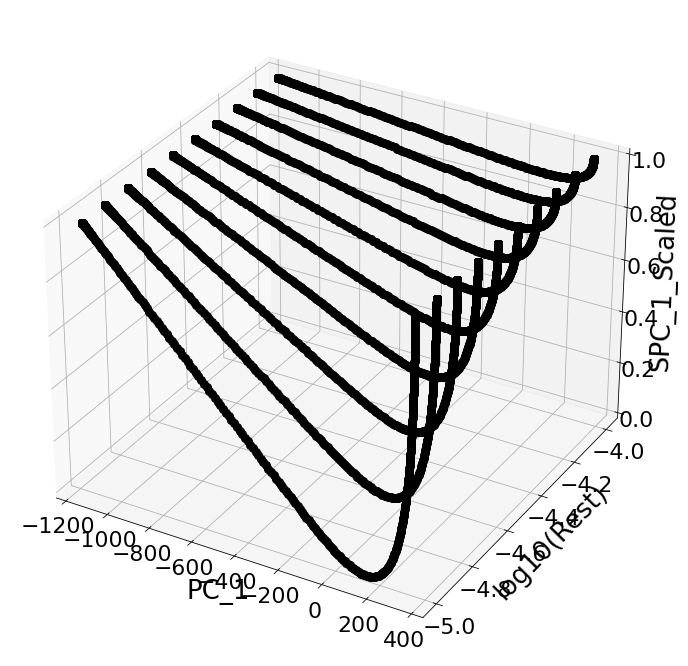

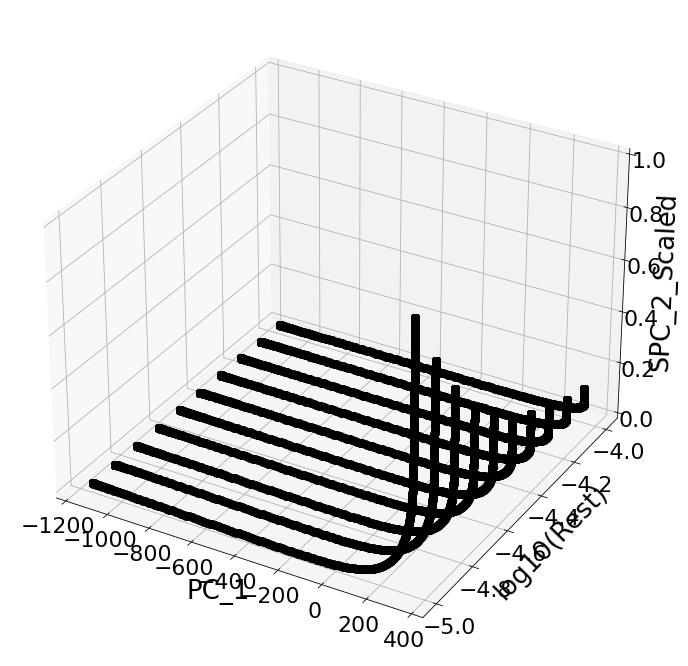

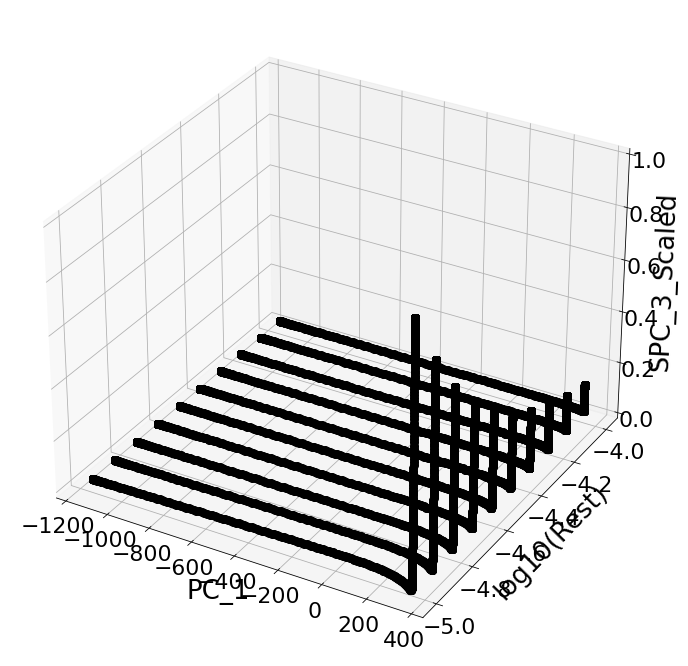

In [6]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(InputDF[InputData.InputVars[1]], InputDF[InputData.InputVars[0]], OutputDF[InputData.OutputVars[0]], 'ok',  linewidth=2)
ax.set_xlabel(InputData.InputVars[1])
ax.set_ylabel(InputData.InputVars[0])
ax.set_zlabel(InputData.OutputVars[0])

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(InputDF[InputData.InputVars[1]], InputDF[InputData.InputVars[0]], OutputDF[InputData.OutputVars[1]], 'ok',  linewidth=2)
ax.set_xlabel(InputData.InputVars[1])
ax.set_ylabel(InputData.InputVars[0])
ax.set_zlabel(InputData.OutputVars[1])

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(InputDF[InputData.InputVars[1]], InputDF[InputData.InputVars[0]], OutputDF[InputData.OutputVars[2]], 'ok',  linewidth=2)
ax.set_xlabel(InputData.InputVars[1])
ax.set_ylabel(InputData.InputVars[0])
ax.set_zlabel(InputData.OutputVars[2])

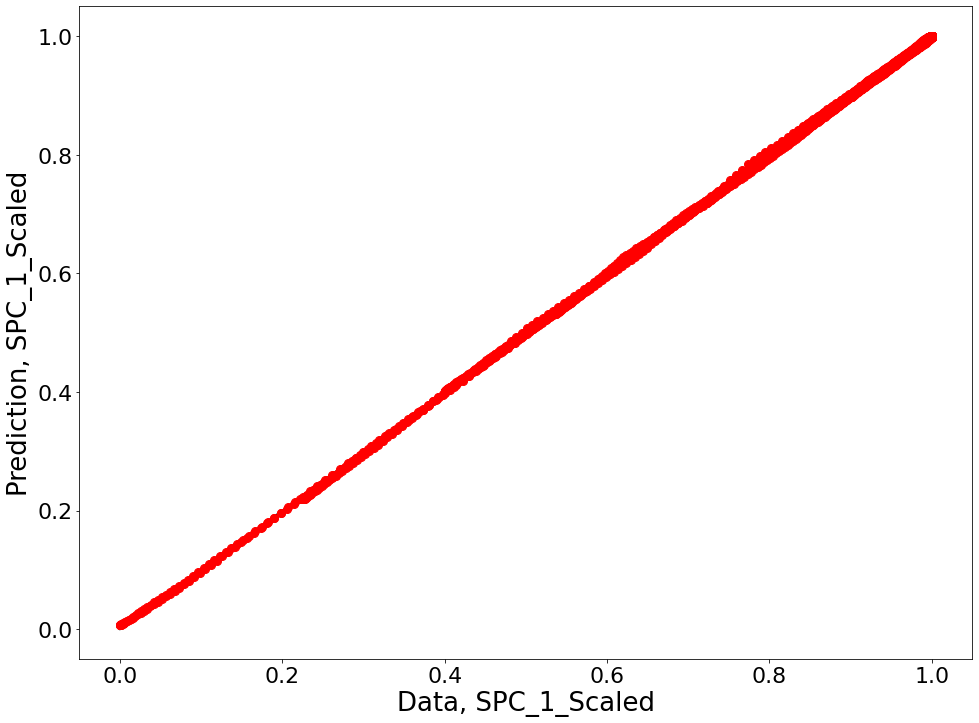

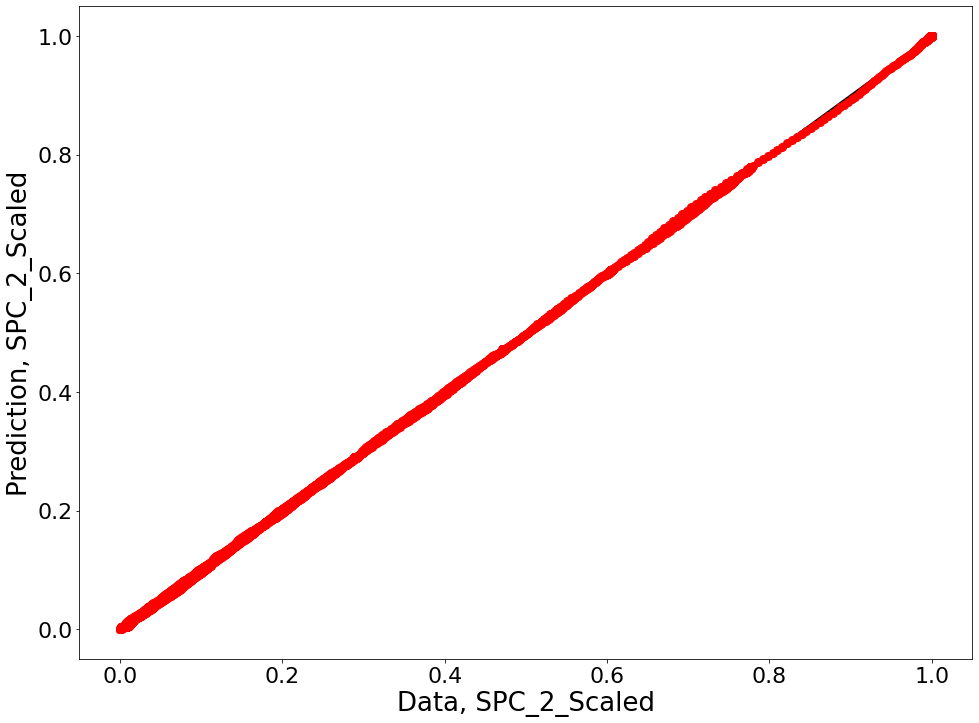

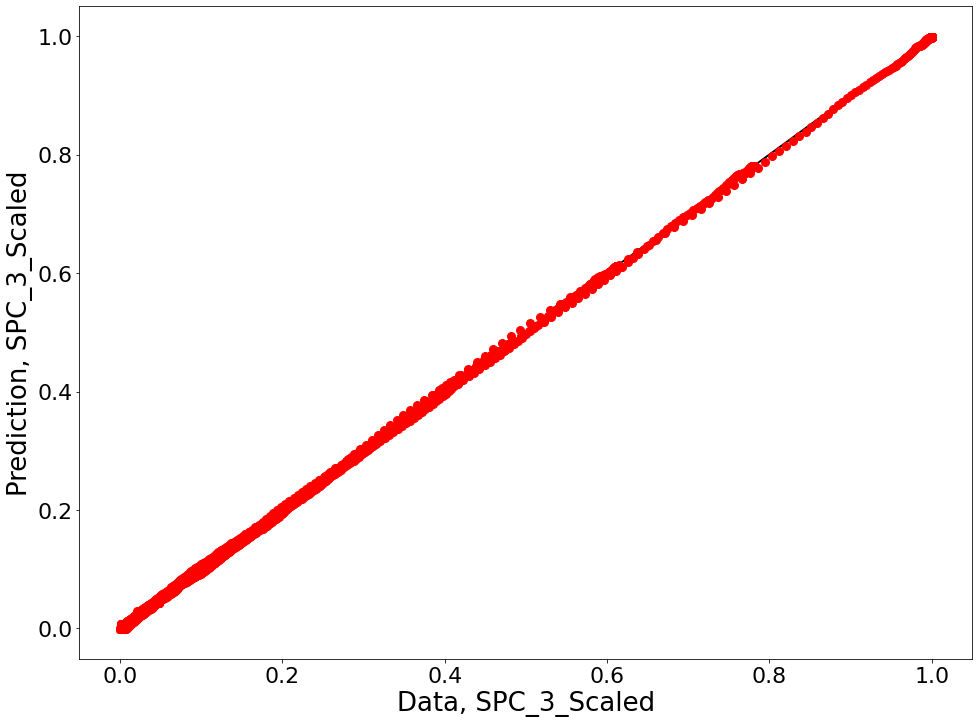

In [7]:
Ny   = len(InputData.OutputVars)
ax   = []
for iy in range(Ny):
    fig    = plt.figure(figsize=(16,12))
    ax.append(plt.axes())
    xMin_  = np.amin(Output[:,iy])
    xMax_  = np.amax(Output[:,iy])
    ax[iy].plot([xMin_,xMax_],[xMin_,xMax_],'k-')
    ax[iy].set_xlabel('Data, '+InputData.OutputVars[iy])
    ax[iy].set_ylabel('Prediction, '+InputData.OutputVars[iy])
    
for iSample in range(NSamples):
    yMat = NN.predict(InputDF[InputData.InputVars])
    for iy in range(Ny):
        ax[iy].plot(Output[:,iy], yMat[:,iy], 'ro')

Text(0.5, 0, 'SPC_3_Scaled')

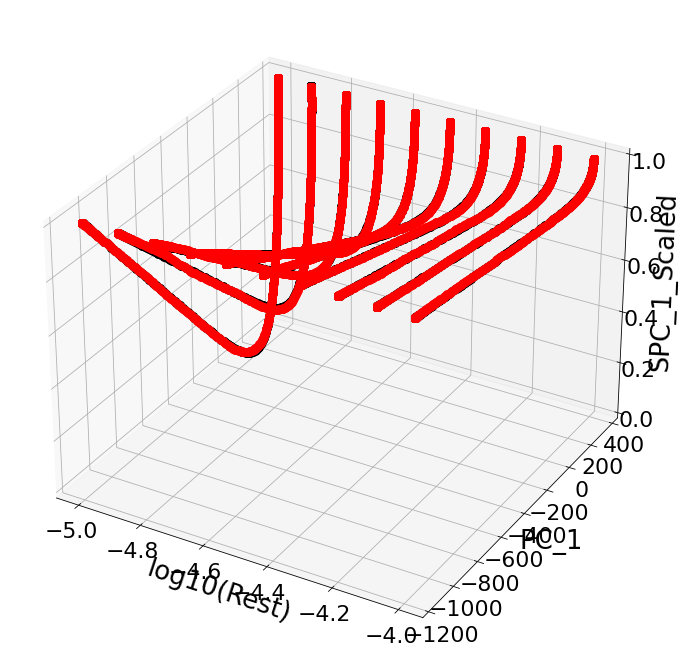

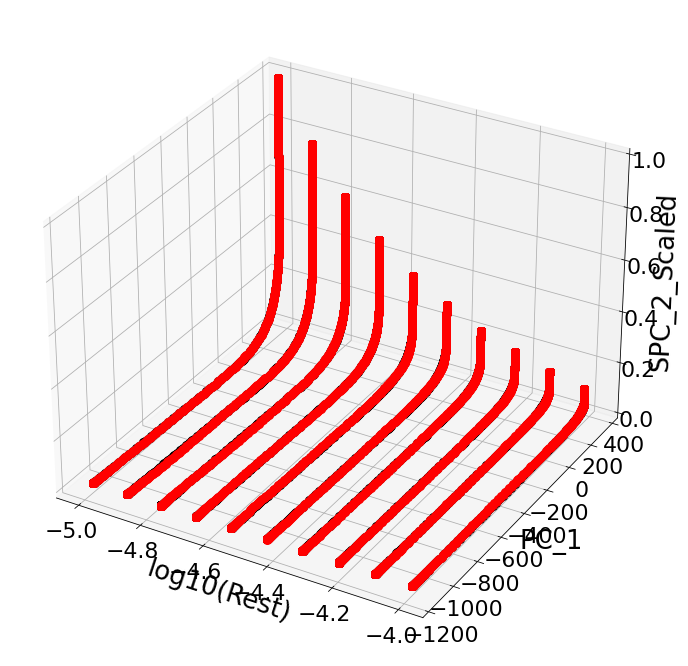

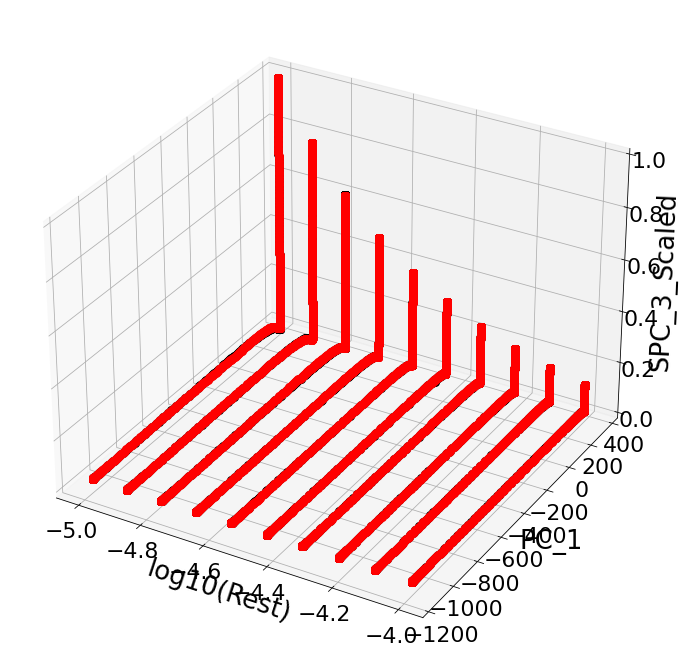

In [8]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax1  = plt.axes(projection='3d')
fig  = plt.figure(figsize=(16,12))
ax2   = plt.axes(projection='3d')
fig  = plt.figure(figsize=(16,12))
ax3   = plt.axes(projection='3d')

ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[0]], 'ok',  linewidth=2)
ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[1]], 'ok',  linewidth=2)
ax3.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[2]], 'ok',  linewidth=2)

for iSample in range(NSamples):
    yMat = NN.predict(InputDF[InputData.InputVars])
    ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,0], 'or',  linewidth=2)
    ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,1], 'or',  linewidth=2)
    ax3.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,2], 'or',  linewidth=2)

ax1.set_xlabel(InputData.InputVars[0])
ax1.set_ylabel(InputData.InputVars[1])
ax1.set_zlabel(InputData.OutputVars[0])

ax2.set_xlabel(InputData.InputVars[0])
ax2.set_ylabel(InputData.InputVars[1])
ax2.set_zlabel(InputData.OutputVars[1])

ax3.set_xlabel(InputData.InputVars[0])
ax3.set_ylabel(InputData.InputVars[1])
ax3.set_zlabel(InputData.OutputVars[2])

In [9]:
### Evaluating on Test Data

FileName  = DirDir + '/pc_data_'+str(NVarsRed) + '/' + InputData.InputFile
InputDF   = pd.read_csv(FileName, header=0)
Input     = InputDF[InputData.InputVars].to_numpy()
VarNames  = list(InputDF.columns)


FileName  = DirDir + '/pc_data_'+str(NVarsRed) + '/' + InputData.OutputFile
OutputDF  = pd.read_csv(FileName, header=0)
Output    = OutputDF[TestOutputVars].to_numpy()

In [10]:
def PredictFun(x, MinVals, MaxVals):
    Range   = MaxVals - MinVals
    yScaled = NN.predict(x)
    return yScaled*Range + MinVals

Text(0.5, 0, 'SPC_3')

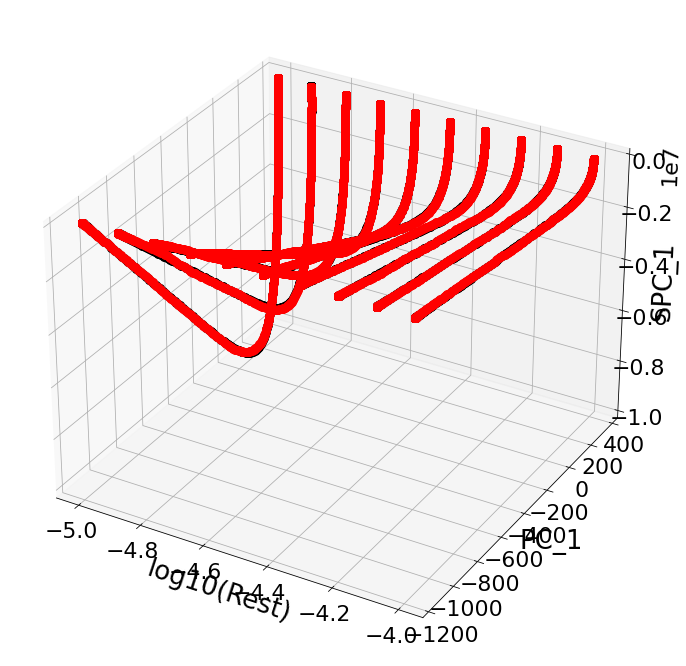

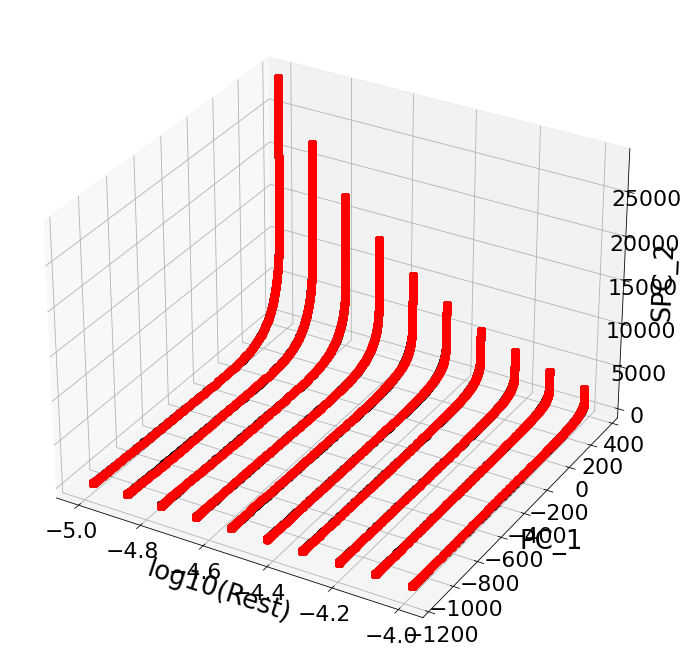

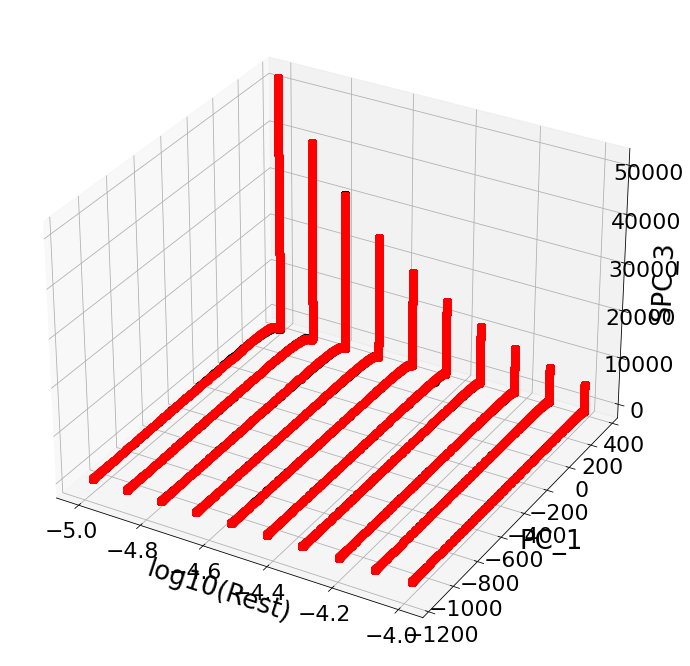

In [11]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax1  = plt.axes(projection='3d')
fig  = plt.figure(figsize=(16,12))
ax2   = plt.axes(projection='3d')
fig  = plt.figure(figsize=(16,12))
ax3   = plt.axes(projection='3d')

ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[TestOutputVars[0]], 'ok',  linewidth=2)
ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[TestOutputVars[1]], 'ok',  linewidth=2)
ax3.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[TestOutputVars[2]], 'ok',  linewidth=2)

for iSample in range(NSamples):
    yMat = PredictFun(InputDF[InputData.InputVars], MinVals, MaxVals)
    
    ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,0], 'or',  linewidth=2)
    ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,1], 'or',  linewidth=2)
    ax3.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,2], 'or',  linewidth=2)

ax1.set_xlabel(InputData.InputVars[0])
ax1.set_ylabel(InputData.InputVars[1])
ax1.set_zlabel(TestOutputVars[0])

ax2.set_xlabel(InputData.InputVars[0])
ax2.set_ylabel(InputData.InputVars[1])
ax2.set_zlabel(TestOutputVars[1])

ax3.set_xlabel(InputData.InputVars[0])
ax3.set_ylabel(InputData.InputVars[1])
ax3.set_zlabel(TestOutputVars[2])

In [12]:
### Defining Surrogate ODE

def f_NN(t, y):
    print(t)
    yy   = np.concatenate((RestVal, y), axis=0)[np.newaxis,...]
    dydt = PredictFun(yy, MinVals, MaxVals)
    return dydt[0,:]

# def f_NN(t, y):
#     print(t)
#     yy   = y[np.newaxis,...]
#     dydt = PredictFun(yy, MinVals, MaxVals)
#     return dydt[0,:]

RestVal =  [-4.] ; y0_pca =  [ 3.42441839e+02 -1.78877349e-02  2.89325323e-03]
0.0
9.590140711634273e-09
1.9180281423268548e-07
2.877042213490282e-07
7.672112569307419e-07
8.524569521452687e-07
9.590140711634273e-07
9.590140711634273e-07
1.1392857530408392e-06
1.2294215939795452e-06
1.6801007986730748e-06
1.7602215461741467e-06
1.8603724805504866e-06
1.8603724805504866e-06
2.49166085556454e-06
2.8073050430715666e-06
4.385525980606701e-06
4.666098591724058e-06
5.0168143556207545e-06
5.0168143556207545e-06
6.392973251463757e-06
7.08105269938526e-06
1.0521449938992768e-05
1.113307611492299e-05
1.189760883483577e-05
1.189760883483577e-05
1.808375569312862e-05
2.1176829122275043e-05
3.664219626800716e-05
3.939159487169287e-05
4.282834312630001e-05
4.282834312630001e-05
5.3812468284718015e-05
5.930453086392702e-05
8.676484375997205e-05
9.164667716371339e-05
9.774896891839006e-05
9.774896891839006e-05
0.00011494673903773164
0.00012354562409740244
0.0001665400493957564


KeyboardInterrupt: 

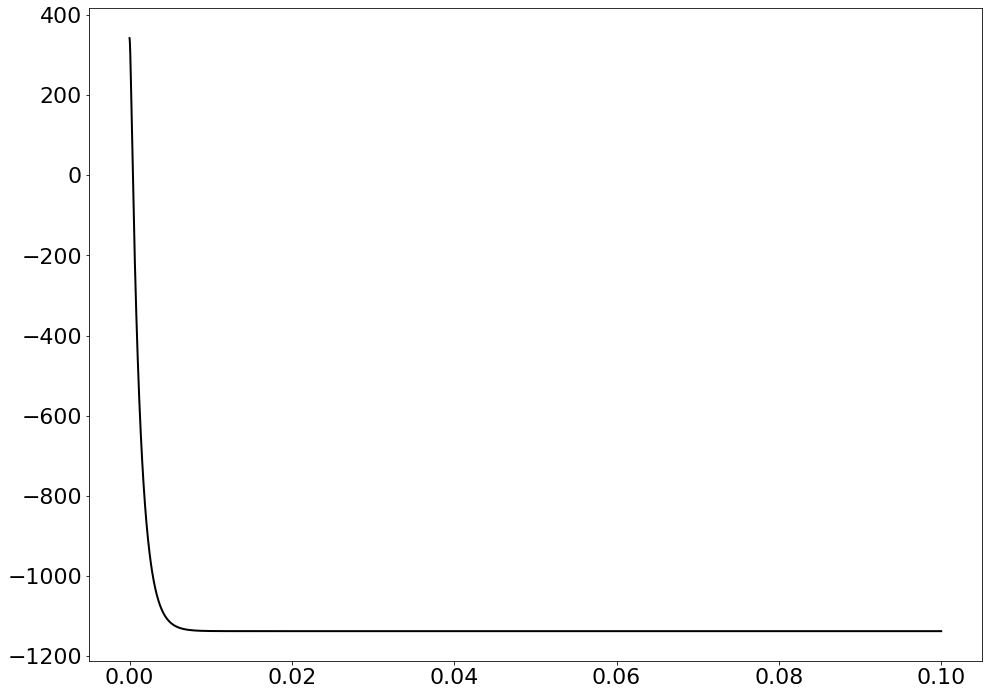

In [18]:
### Evaluating on Test Data

FileName       = DirDir + '/orig_data/ResidenceTimes.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVecTest = np.log10(Data.to_numpy())

iPC = 0

fig = plt.figure(figsize=(16,12))
for iTest in CasesVec:
    RestVal                      = RestValVecTest[iTest]

    FileName                     = DirDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    InputDataTest                = pd.read_csv(FileName, header=0)
    tVec                         = InputDataTest['t'].to_numpy()
    InputDataTest['log10(Rest)'] = RestVal * np.ones(len(tVec))
    yMat_pca                     = InputDataTest[InputData.InputVars].to_numpy()[:,1:]
    y0_pca                       = yMat_pca[0,:]
    print('RestVal = ', RestVal, '; y0_pca = ', y0_pca)
    
    plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE', lw=2)
    
    tNN      = []
    tt       = 0.0
    dt       = 1.e-14
    tStratch = 1.03
    tMax     = tVec[-1]
    while tt < tMax:
        tNN.append(tt)
        tt += dt
        dt *= tStratch
    #tNN          = tVec
    tNN      = np.array(tNN)
    
    output       = solve_ivp( f_NN, tNN[[0,-1]], y0_pca, method=SOLVER, t_eval=tNN, atol=atol )
    tNN          = output.t
    yMat_pca_    = output.y.T
    
    plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('PC_'+str(iPC+1))
plt.legend()

In [19]:
iPC = 0

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE',                   lw=2)
plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)
plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('$PC_'+str(iPC+1)+'$')
plt.legend()
plt.ylim([-2000.0, 2500.])
#plt.ylim([-5.0, 5.])
#plt.ylim([-0.3, 0.3])

In [15]:
FileName = OutputDir+'/pca_'+str(NVarsRed)+'/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

In [16]:
yMatt    = (yMat_pca.dot(A)) *D[:,0] + C[:,0]
yMat_    = (yMat_pca_.dot(A))*D[:,0] + C[:,0]

In [20]:
FileName = DirDir + '/orig_data/y.csv.1'
Data     = pd.read_csv(FileName, header=0)
VarNames = list(Data.columns)

VarOI    = 'CH4'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
        
fig = plt.figure(figsize=(16,12))
for iTest in CasesVec:

    FileName     = DirDir + '/orig_data/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat         = Data.to_numpy()[:,1:]
        
    plt.plot(tVec, yMat[:,iVar-1],  '-k', label='From ODE',                   lw=2)
    plt.plot(tVec, yMatt[:,iVar-1], '-g', label='From PCA',                   lw=2)
    plt.plot(tNN,  yMat_[:,iVar-1], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel(VarOI)
plt.legend()